In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import nltk.sentiment
import re

import warnings
warnings.filterwarnings('ignore')

from prepare import prep_readme_data
import model

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

In [3]:
movie_title = pd.read_csv("IMDb movies.csv")

In [4]:
# What is are biggest markets in terms of movie production? 

movie_title.groupby("country").title.count().sort_values(ascending=False).nlargest(5)

country
USA       27490
India      5540
UK         3869
France     2975
Japan      2850
Name: title, dtype: int64

In [5]:
# What year did most movies get published?

movie_title.groupby("date_published").title.count().nlargest(10)

date_published
2010    111
1999    105
2008    101
1997     92
1985     90
1996     89
2009     89
1989     85
2011     85
1987     84
Name: title, dtype: int64

In [6]:
# What data range do we have? 

movie_title.date_published.min(), movie_title.date_published.max()

('1906-12-26', '2020-05-22')

In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

For the purposes of this project, we will only look to use movies from the US. If the opportunity to scale up the project is possible, then we will add additional countries.

In [8]:
df = movie_title[(movie_title.country == "USA")]

In [9]:
# we see that we have a couple of missing values.
df.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      0
language                   307
director                    28
writer                     191
production_company        1139
actors                      22
description                 76
avg_vote                     0
votes                        0
budget                   17213
usa_gross_income         19940
worlwide_gross_income    19710
metascore                21145
reviews_from_users         279
reviews_from_critics      1728
dtype: int64

**Steps for Removing Null Values**:

1. The movie description will be a large part indicator or similarity, and as such, I want movies that have a description. I will drop any null values in this column
1. I will explore that language column, as I suspect at this moment that these shoud be all inglish
1. Similarly to the description, the director would play a big influence and as such I am thinking of dropping all null values from this column
1. While the meta score value would be really useful - there are too many missing values, and as such I will drop this column. Same for the `reviews_from_critics`
1. Might be able to impude a value for the missing `reviews_from_users`
1. I might be able to find the missing writers from the other IMBD file


In [10]:
# Given that hte majority of the movies are exclusively English, and we know that we are only looking at movies
# made in the US, I can speculate that it is very likely these movies were at least partially made in english
# As such, I will impode the missing values

df.language.value_counts()

English                               23976
English, Spanish                        695
English, French                         440
English, German                         198
English, Italian                        195
                                      ...  
English, Afrikaans, Xhosa                 1
English, Icelandic, Italian               1
English, Russian, Esperanto               1
English, Japanese, German, Chinese        1
English, Russian, Korean                  1
Name: language, Length: 629, dtype: int64

In [11]:
df.language = df.language.fillna("English")

In [12]:
# remove nulls from director and description

df = df[df.description.notnull()]

In [13]:
df = df[df.director.notnull()]

In [14]:
df = df[df.writer.notnull()]

In [15]:
# What is the avg budget for all movies so that we can use it to impude values?

df.budget = df.budget.fillna("$ 0")

In [16]:
df = df[~df.budget.str.contains("ESP")]

df = df[~df.budget.str.contains("GBP")]

df = df[~df.budget.str.contains("CAD")]

df = df[~df.budget.str.contains("PYG")]

df = df[~df.budget.str.contains("AUD")]

df = df[~df.budget.str.contains("EUR")]

df = df[~df.budget.str.contains("RUR")]

In [17]:
avg_budget = df.budget.str.replace("$", '').astype(int).mean()

In [18]:
df.budget = df.budget.str.replace("$", '').astype(int)

In [19]:
df.budget = df.budget.replace(0, avg_budget)

In [20]:
# We will do something similar for US gross income

median_income = df[(df.usa_gross_income.notnull()) & (df.usa_gross_income.str.contains("$", regex=False))].usa_gross_income.str.replace("$", '').astype(int).median()

In [21]:
df.usa_gross_income = df.usa_gross_income.fillna("$ 0")

In [22]:
df.usa_gross_income = (
    df[df.usa_gross_income.str.contains("$", regex=False)]
    .usa_gross_income.str.replace("$", '')
    .astype(int)
    .replace(0, median_income)
)

In [23]:
# Remove columns with too many null values

df = df.drop(columns=["worlwide_gross_income", "metascore", "reviews_from_users", "reviews_from_critics"])

In [24]:
# Drop any remaining null values

df = df.dropna()

In [25]:
# Now we have no null values, and still have over 26000 movie titles

df.isnull().sum(), df.shape

(imdb_title_id         0
 title                 0
 original_title        0
 year                  0
 date_published        0
 genre                 0
 duration              0
 country               0
 language              0
 director              0
 writer                0
 production_company    0
 actors                0
 description           0
 avg_vote              0
 votes                 0
 budget                0
 usa_gross_income      0
 dtype: int64, (26102, 18))

## NLP Exploration

In [26]:
df_prep = prep_readme_data(df, "description")

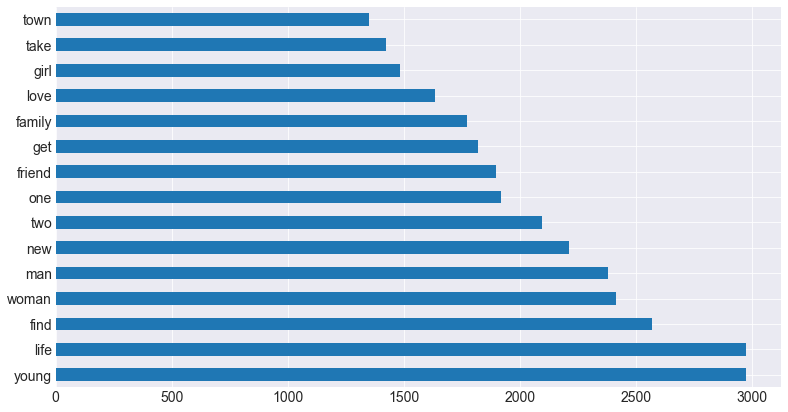

In [27]:
# What are the most common words in movie descriptions?

all_words = clean(' '.join(df.description))

pd.Series(all_words).value_counts().head(15).plot.barh()


### Common words by genre?

In [28]:
# What are the top most common genres?

df.genre.value_counts().head(5)

Drama             2294
Comedy            1810
Comedy, Drama      953
Horror             947
Drama, Romance     886
Name: genre, dtype: int64

In [29]:
drama = clean(' '.join(df[df.genre == "Drama"].description))
comedy = clean(' '.join(df[df.genre == "Comedy"].description))
comedy_drama = clean(' '.join(df[df.genre == "Comedy, Drama"].description))
horror = clean(' '.join(df[df.genre == "Horror"].description))
drame_romance = clean(' '.join(df[df.genre == "Drama, Romance"].description))

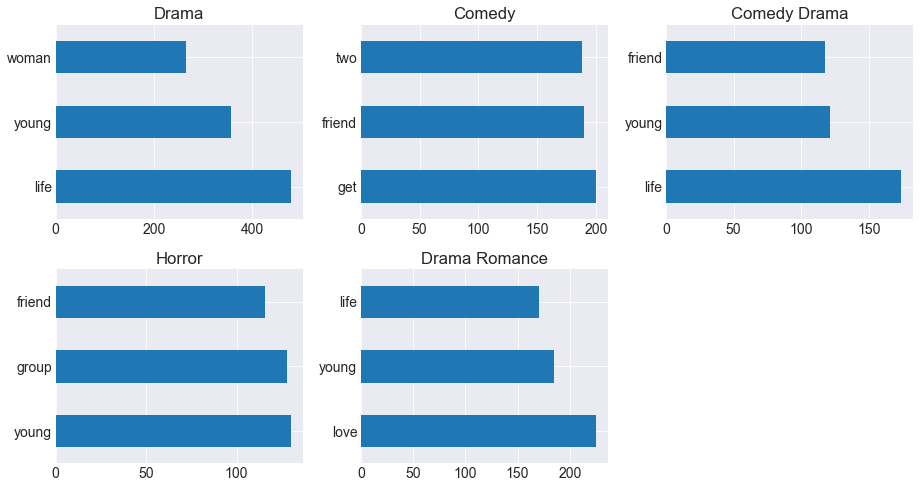

In [30]:
plt.subplot(2,3,1)
pd.Series(drama).value_counts().head(3).plot.barh()
plt.title("Drama")
plt.subplot(2,3,2)
pd.Series(comedy).value_counts().head(3).plot.barh()
plt.title("Comedy")
plt.subplot(2,3,3)
pd.Series(comedy_drama).value_counts().head(3).plot.barh()
plt.title("Comedy Drama")
plt.subplot(2,3,4)
pd.Series(horror).value_counts().head(3).plot.barh()
plt.title("Horror")
plt.subplot(2,3,5)
pd.Series(drame_romance).value_counts().head(3).plot.barh()
plt.title("Drama Romance")

plt.tight_layout()
plt.show()


### Common words throughout time?

In [31]:
def most_frequent_bigram(s: pd.Series) -> str:
    # your code might be more or less complicated here, depending on how much
    # text prep you've already done or more you want to do in this function
    words = clean(' '.join(s))
    most_common_bigram = pd.Series(nltk.bigrams(words)).value_counts().head(1).index
    return most_common_bigram

In [32]:
df.date_published = pd.to_datetime(df.date_published)

In [33]:
most_common_bigrams = df.set_index('date_published').resample('Y').description.agg([most_frequent_bigram, "count"])

In [34]:
most_common_bigrams["most_frequent_bigram"][0]

('antony', 'ulimately')

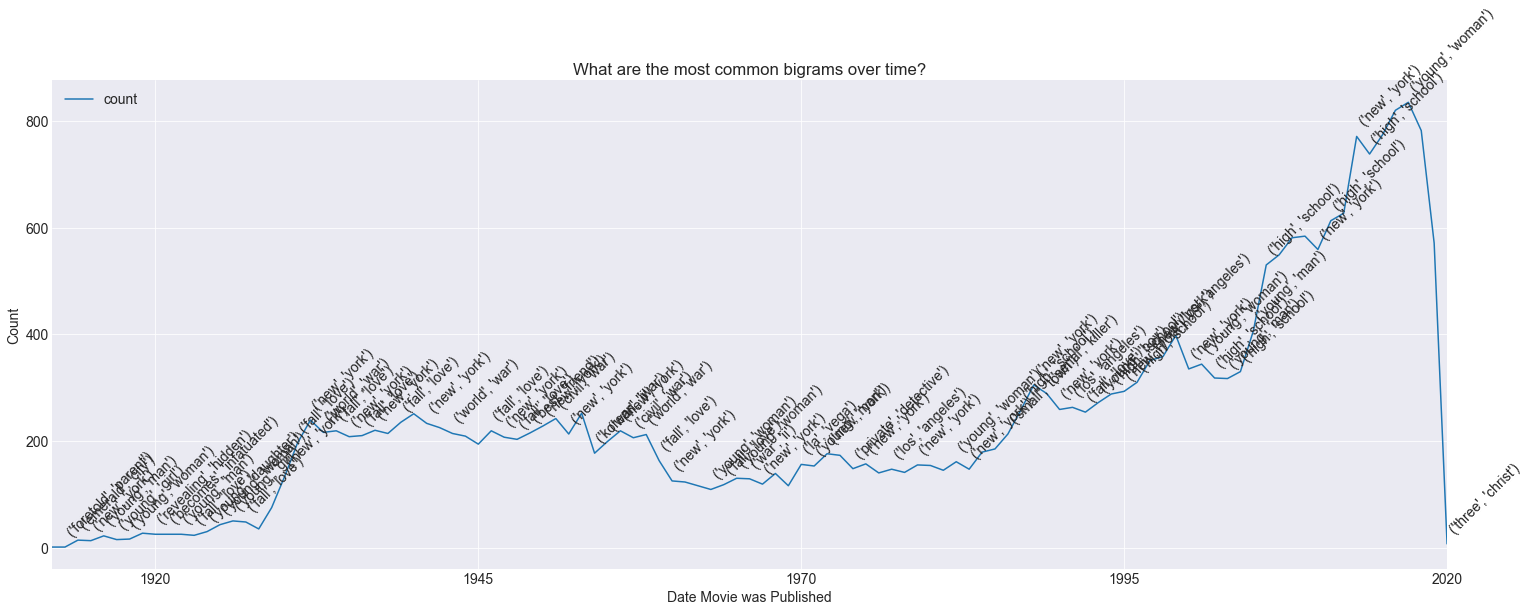

In [35]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over time?")
plt.ylabel("Count")
plt.xlabel("Date Movie was Published")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"][i] != most_common_bigrams["most_frequent_bigram"][i-1]:
        ax.text(f"{most_common_bigrams.index[i]}", most_common_bigrams["count"][i] + 20,  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

### Common bigrams in high voted movies vs low?

In [36]:
most_common_bigrams = df.groupby("avg_vote").description.agg([most_frequent_bigram, "count"])

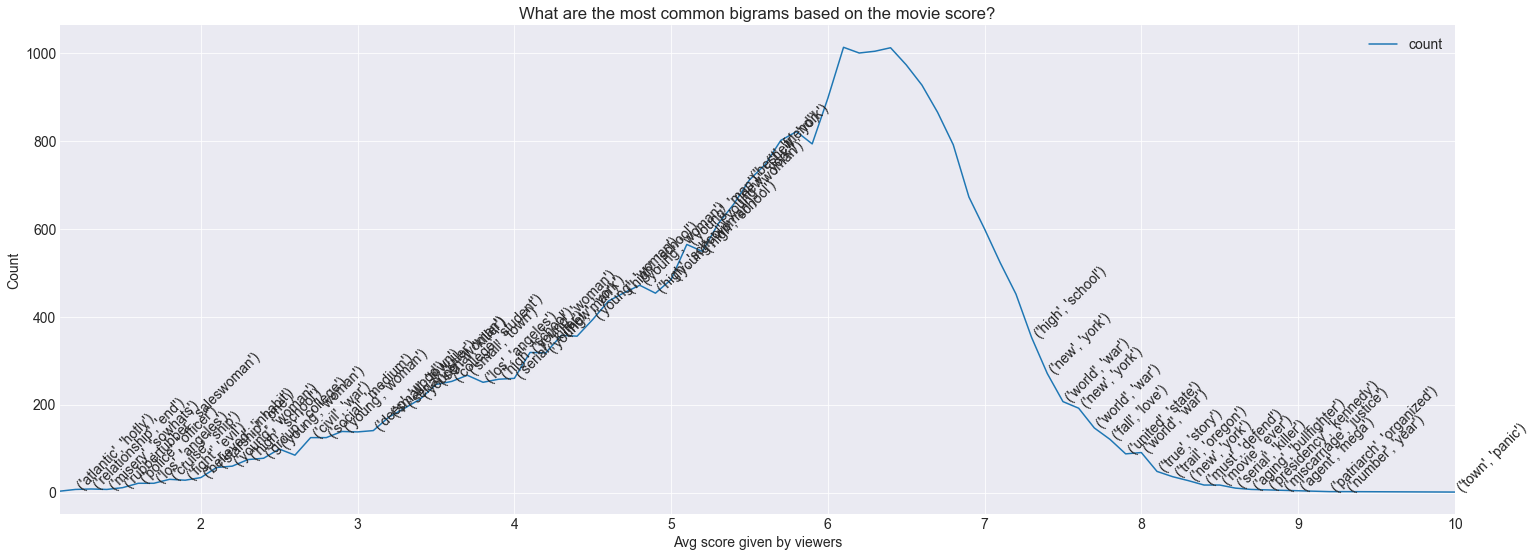

In [37]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams based on the movie score?")
plt.ylabel("Count")
plt.xlabel("Avg score given by viewers")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"].iloc[i] != most_common_bigrams["most_frequent_bigram"].iloc[i-1]:
        ax.text(most_common_bigrams.index[i], most_common_bigrams["count"].iloc[i],  f"{most_common_bigrams.most_frequent_bigram.iloc[i]}", rotation = 45)

### Common words in high grossing movies vs low?

In [38]:
df["usa_gross_bin"] = pd.cut(df.usa_gross_income, 10, labels=[1,2,3,4,5,6,7,8,9, 10])

In [39]:
most_common_bigrams = df.groupby("usa_gross_bin").description.agg([most_frequent_bigram, "count"])

In [40]:
df[df["usa_gross_bin"] == 10]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin
65123,tt2488496,Star Wars: Episode VII - The Force Awakens,Star Wars: Episode VII - The Force Awakens,2015,2015-12-17,"Action, Adventure, Sci-Fi",138,USA,English,J.J. Abrams,...,"Three decades after the Empire's defeat, a new...",7.9,800030,245000000.0,936662225.0,three decades after the empires defeat a new t...,"[three, decades, after, the, empires, defeat, ...",three decade after the empire defeat a new thr...,three decade empire defeat new threat arises m...,10
71243,tt4154796,Avengers: Endgame,Avengers: Endgame,2019,2019-04-25,"Action, Adventure, Drama",181,USA,"English, Japanese, Xhosa, German","Anthony Russo, Joe Russo",...,After the devastating events of,8.5,602792,356000000.0,858373000.0,after the devastating events of,"[after, the, devastating, events, of]",after the devastating event of,devastating event,10


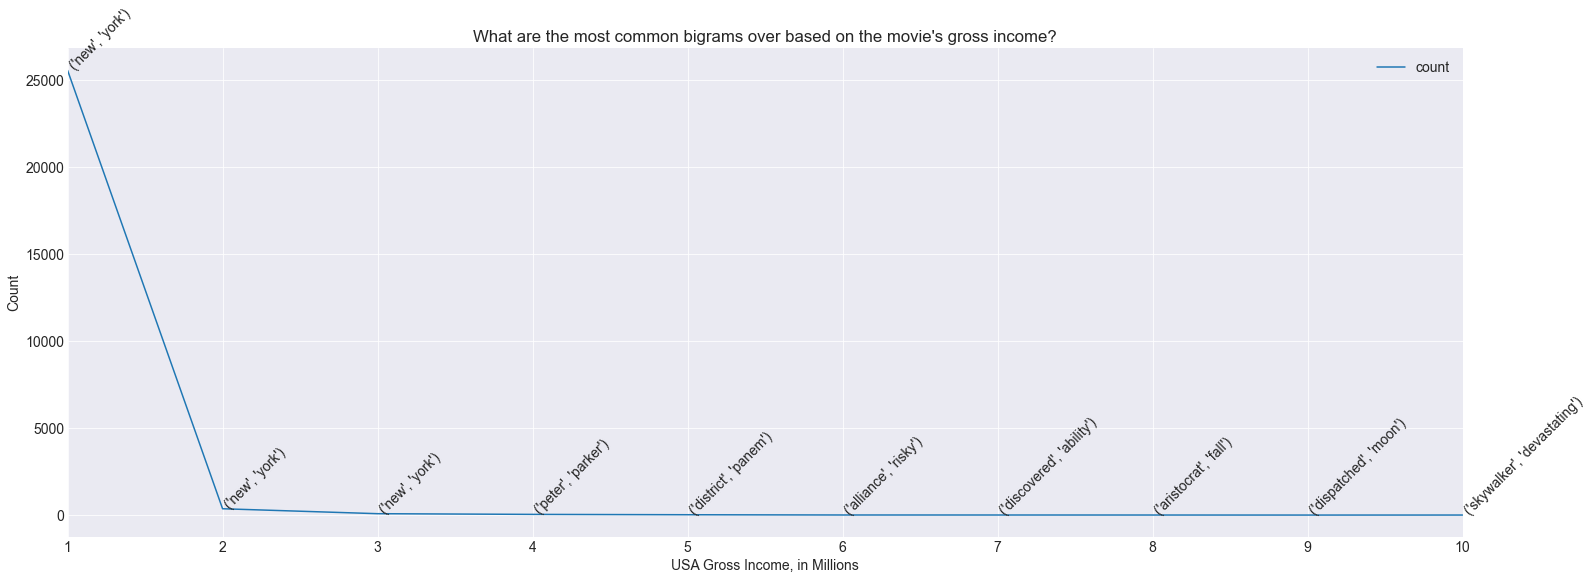

In [41]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over based on the movie's gross income?")
plt.ylabel("Count")
plt.xlabel("USA Gross Income, in Millions")
for i in most_common_bigrams.index:
    ax.text(i-1, most_common_bigrams["count"][i],  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

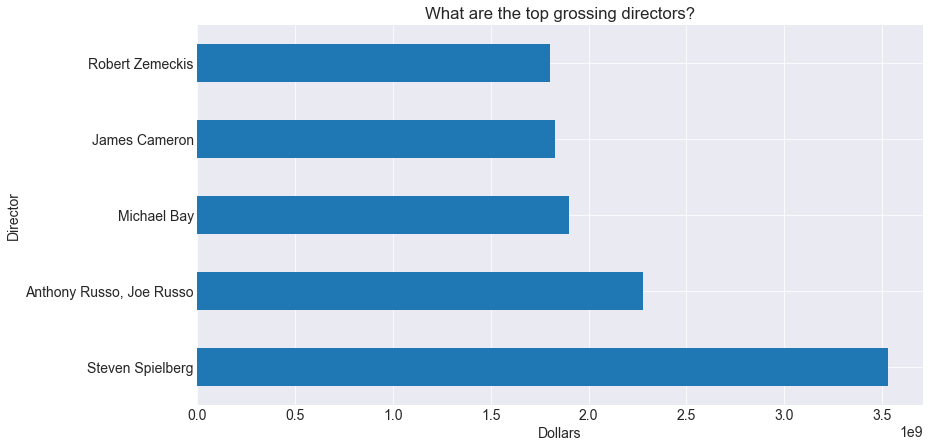

In [99]:
# what are highest grossing directors of all times?


df.groupby("director").usa_gross_income.sum().sort_values(ascending=False).head(5).plot.barh()
plt.title("What are the top grossing directors?")
plt.xlabel("Dollars")
plt.ylabel("Director")
plt.show()

Text(0, 0.5, 'Genre')

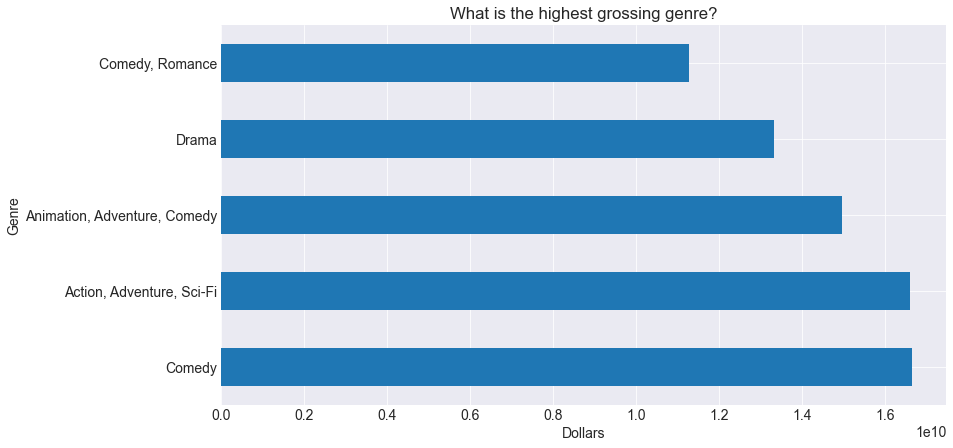

In [106]:
# what are the top genres by genre?

df.groupby("genre").usa_gross_income.sum().sort_values(ascending=False).head(5).plot.barh()
plt.title("What is the highest grossing genre?")
plt.xlabel("Dollars")
plt.ylabel("Genre")

Text(0, 0.5, 'Director')

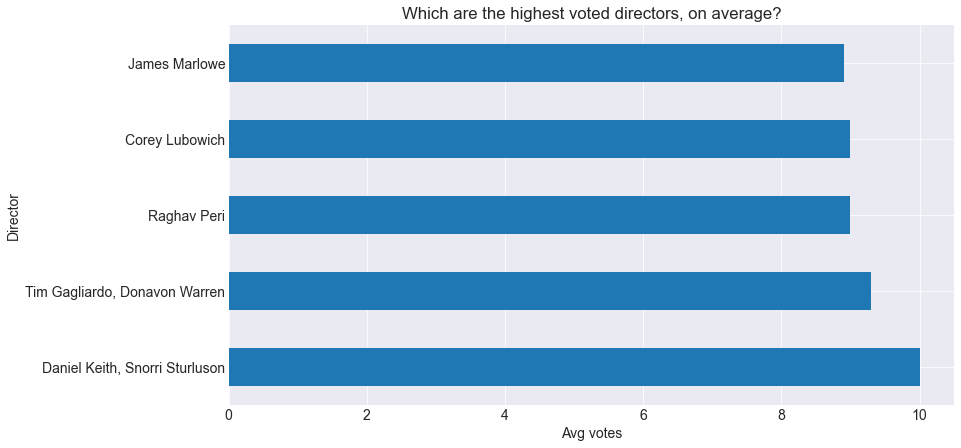

In [119]:
# what are the highest voted directors?

df.groupby("director").avg_vote.mean().sort_values(ascending=False).head(5).plot.barh()
plt.title("Which are the highest voted directors, on average?")
plt.xlabel("Avg votes")
plt.ylabel("Director")

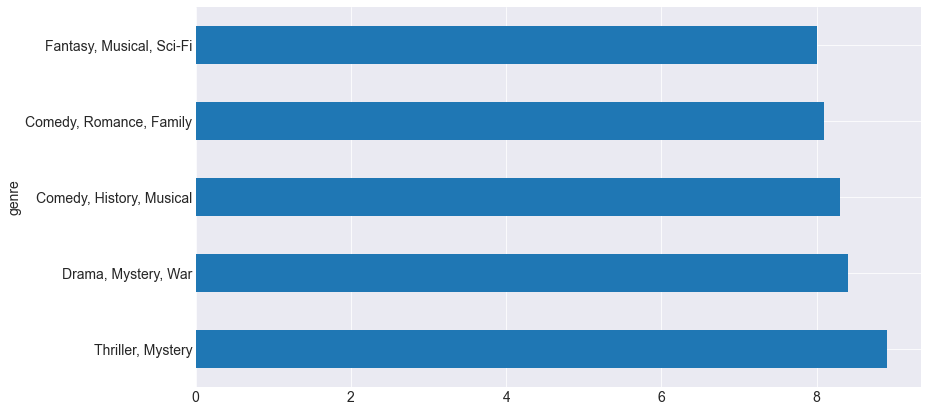

In [118]:
# What are the highest voted genres?

df.groupby("genre").avg_vote.mean().sort_values(ascending=False).head(5).plot.barh()

# Modeling

For modeling, we will most likely need to do a bag of words, and then use those features are a metric for clustering

The simple recommendation model:

* We will look to do a traditional clustering, by looking at features that are already numerical. These features will be:
    * Year release
    * Run time
    * Avg vote
    * Do a `One Hot Encoder` for genre
  
A more advance model would look to use NLP practices to actually model based on the description, on top of some of the other features previously mentioned.
 

In [44]:
df

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,The fabled queen of Egypt's affair with Roman ...,5.2,420,4.500000e+04,5548375.0,the fabled queen of egypts affair with roman g...,"[the, fabled, queen, of, egypts, affair, with,...",the fabled queen of egypt affair with roman ge...,fabled queen egypt affair roman general marc a...,1
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913-01-01,"Biography, Drama",60,USA,English,Sidney Olcott,...,"An account of the life of Jesus Christ, based ...",5.7,438,4.784118e+06,5548375.0,an account of the life of jesus christ based o...,"[an, account, of, the, life, of, jesus, christ...",an account of the life of jesus christ based o...,account life jesus christ based book new testa...,1
15,tt0003167,"Home, Sweet Home","Home, Sweet Home",1914,1914-05-17,Drama,55,USA,English,D.W. Griffith,...,John Howard Payne at his most miserable point ...,5.7,170,4.784118e+06,5548375.0,john howard payne at his most miserable point ...,"[john, howard, payne, at, his, most, miserable...",john howard payne at his most miserable point ...,john howard payne miserable point life writes ...,1
20,tt0003643,The Avenging Conscience: or 'Thou Shalt Not Kill',The Avenging Conscience: or 'Thou Shalt Not Kill',1914,1914-08-24,"Crime, Drama, Horror",78,USA,English,D.W. Griffith,...,Prevented from dating his sweetheart by his un...,6.5,1050,4.784118e+06,5548375.0,prevented from dating his sweetheart by his un...,"[prevented, from, dating, his, sweetheart, by,...",prevented from dating his sweetheart by his un...,prevented dating sweetheart uncle young man tu...,1
21,tt0003657,The Bargain,The Bargain,1914,1914-12-03,Western,70,USA,English,Reginald Barker,...,After the bandit Jim Stokes robs the stage he ...,6.6,121,4.784118e+06,5548375.0,after the bandit jim stokes robs the stage he ...,"[after, the, bandit, jim, stokes, robs, the, s...",after the bandit jim stokes robs the stage he ...,bandit jim stokes robs stage wounded fleeing r...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81227,tt9783778,Adventures of Aladdin,Adventures of Aladdin,2019,2019-05-13,"Adventure, Fantasy",87,USA,English,Glenn Campbell,...,"With the help of a magical lamp, an impoverish...",1.7,998,4.784118e+06,5548375.0,with the help of a magical lamp an impoverishe...,"[with, the, help, of, a, magical, lamp, an, im...",with the help of a magical lamp an impoverishe...,help magical lamp impoverished young man trans...,1
81239,tt9815714,The Hard Way,The Hard Way,2019,2019-03-05,Action,92,USA,English,Keoni Waxman,...,After learning his brother died on a mission i...,4.8,1734,3.000000e+06,5548375.0,after learning his brother died on a mission i...,"[after, learning, his, brother, died, on, a, m...",after learning his brother died on a mission i...,learning brother died mission romania former s...,1
81246,tt9831136,The Banana Splits Movie,The Banana Splits Movie,2019,2019-08-13,"Comedy, Horror, Sci-Fi",89,USA,English,Danishka Esterhazy,...,A boy named Harley and his family (brother Aus...,5.0,1691,4.784118e+06,5548375.0,a boy named harley and his family brother aust...,"[a, boy, named, harley, and, his, family, brot...",a boy named harley and his family brother aust...,boy named harley family brother austin mother ...,1
81254,tt9860860,Abduction 101,Abduction 101,2019,2019-01-01,Horror,77,USA,English,"Robin Entreinger, Steve Noir",...,Three beautiful women find a strange house in ...,2.4,146,5.000000e+05,5548375.0,three beautiful women find a strange house in ...,"[three, beautiful, women, find, a, strange, ho...",three beautiful woman find a strange house in ...,three beaut

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

In [48]:
tfidfs = tfidf.fit_transform(df.clean_lemmatized)
tfidfs

<26102x29585 sparse matrix of type '<class 'numpy.float64'>'
	with 389280 stored elements in Compressed Sparse Row format>

In [73]:
test = tfidf.fit_transform(df.genre)

In [49]:
from sklearn.cluster import KMeans

In [75]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=100)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(tfidfs)


In [76]:
tfidfs

<26102x29585 sparse matrix of type '<class 'numpy.float64'>'
	with 389280 stored elements in Compressed Sparse Row format>

In [77]:
df["cluster"] = predictions_4

In [78]:
df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin,cluster
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,5.2,420,4.500000e+04,5548375.0,the fabled queen of egypts affair with roman g...,"[the, fabled, queen, of, egypts, affair, with,...",the fabled queen of egypt affair with roman ge...,fabled queen egypt affair roman general marc a...,1,51
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913-01-01,"Biography, Drama",60,USA,English,Sidney Olcott,...,5.7,438,4.784118e+06,5548375.0,an account of the life of jesus christ based o...,"[an, account, of, the, life, of, jesus, christ...",an account of the life of jesus christ based o...,account life jesus christ based book new testa...,1,73
15,tt0003167,"Home, Sweet Home","Home, Sweet Home",1914,1914-05-17,Drama,55,USA,English,D.W. Griffith,...,5.7,170,4.784118e+06,5548375.0,john howard payne at his most miserable point ...,"[john, howard, payne, at, his, most, miserable...",john howard payne at his most miserable point ...,john howard payne miserable point life writes ...,1,15
20,tt0003643,The Avenging Conscience: or 'Thou Shalt Not Kill',The Avenging Conscience: or 'Thou Shalt Not Kill',1914,1914-08-24,"Crime, Drama, Horror",78,USA,English,D.W. Griffith,...,6.5,1050,4.784118e+06,5548375.0,prevented from dating his sweetheart by his un...,"[prevented, from, dating, his, sweetheart, by,...",prevented from dating his sweetheart by his un...,prevented dating sweetheart uncle young man tu...,1,56
21,tt0003657,The Bargain,The Bargain,1914,1914-12-03,Western,70,USA,English,Reginald Barker,...,6.6,121,4.784118e+06,5548375.0,after the bandit jim stokes robs the stage he ...,"[after, the, bandit, jim, stokes, robs, the, s...",after the bandit jim stokes robs the stage he ...,bandit jim stokes robs stage wounded fleeing r...,1,44


In [79]:
df[df.cluster == 1][["title", "year", "genre", "duration", "cluster"]]

,title,year,genre,duration,cluster
105,Tom Sawyer,1917,"Adventure, Comedy, Drama",59,1
244,My Boy,1921,"Comedy, Drama",55,1
333,Why Worry?,1923,"Adventure, Comedy, Family",63,1
340,Captain January,1924,Drama,64,1
478,Kid Boots,1926,"Comedy, Romance",77,1
...,...,...,...,...,...
78973,The Curse of Lilith Ratchet,2018,Horror,104,1
79265,Love Shot,2018,"Comedy, Crime, Romance",80,1
79476,Best F(r)iends: Volume 2,2018,"Comedy, Drama, Thriller",93,1
79490,A Child's Voice,2018,"Drama, Horror, Mystery",82,1


In [67]:
df[df.cluster == 1].duration.mean()

93.5483125882202

In [68]:
df[df.cluster == 2].duration.mean()

97.25618292113859